In [4]:
# automatically reflect changes in imported modules
%load_ext autoreload
%autoreload 2

from pathlib import Path
import numpy as np
import utils
import matplotlib.pyplot as plt

import utils.logging_config
import logging
logger = logging.getLogger("task1")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
DATA_ROOT = Path('data')
DATA_NAME = 'data.txt'
# DATA_NAME = 'data0.txt'
# DATA_NAME = 'data1.txt'
NBINS = 100

In [6]:
points, columns = utils.load_data(DATA_ROOT / DATA_NAME)
logger.debug(f"Fetched {points.shape[0]} points, columns: {columns}")
# reorder the columns to match the expected order (x, y, z, mass)
particles = points[:, [2, 3, 4, 1]]

particles = particles[::10, ...]
# particles = particles[:5000, ...]
# TODO: remove this

# particles = utils.remove_outliers(particles)

13:55:14 - utils.load - Loaded 50010 rows and 10 columns from data/data.txt
13:55:14 - task1 - Fetched 50010 points, columns: ['ID', 'MASS', 'X', 'Y', 'Z', 'VX', 'VY', 'VZ', 'SOFTENING', '?']


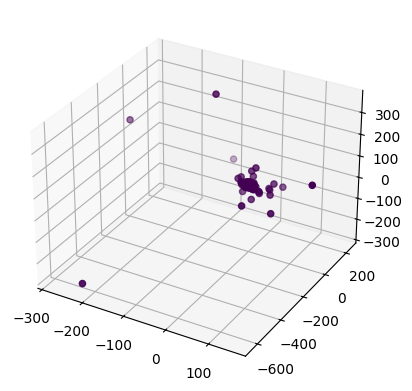

In [7]:
# plot the distribution of the particles
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(particles[:,0], particles[:,1], particles[:,2], cmap='viridis', c=particles[:,3])
plt.show()

/home/remy/.local/share/virtualenvs/projects-X-9bmgL6/lib/python3.12/site-packages/numpy/_core/function_base.py:314: RuntimeWarning: overflow encountered in power
  return _nx.power(base, y)
/home/remy/Documents/Uni/HS24/Computational Astrophysics/projects/nbody/utils/particles.py:19: RuntimeWarning: overflow encountered in power
  volume = 4/3 * np.pi * (r_bins[1:]**3 - r_bins[:-1]**3)
/home/remy/Documents/Uni/HS24/Computational Astrophysics/projects/nbody/utils/particles.py:19: RuntimeWarning: invalid value encountered in subtract
  volume = 4/3 * np.pi * (r_bins[1:]**3 - r_bins[:-1]**3)
/home/remy/Documents/Uni/HS24/Computational Astrophysics/projects/nbody/utils/model.py:11: RuntimeWarning: overflow encountered in power
  rho = M / (2 * np.pi) * a / (r_bins * (r_bins + a)**3)
/home/remy/Documents/Uni/HS24/Computational Astrophysics/projects/nbody/utils/model.py:11: RuntimeWarning: overflow encountered in multiply
  rho = M / (2 * np.pi) * a / (r_bins * (r_bins + a)**3)
/home/remy/.

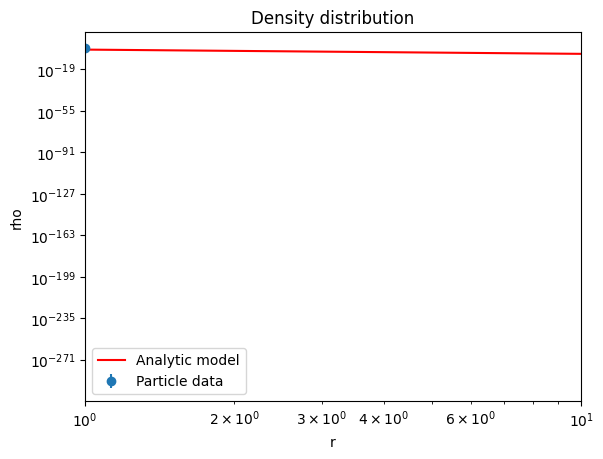

In [8]:
all_r = utils.r_distribution(particles)
rbins = np.logspace(np.min(all_r), np.max(all_r), NBINS)
rho, err = utils.density_distribution(rbins, particles, ret_error=True)
rho_t = utils.model_density_distribution(rbins)


plt.figure()
plt.title('Density distribution')
# set the scale to log-log
plt.xscale('log')
plt.yscale('log')
plt.xlabel('r')
plt.ylabel('rho')
plt.errorbar(rbins, rho, yerr=err, fmt='o', label="Particle data")
plt.plot(rbins, rho_t, 'r-', label="Analytic model")
plt.legend()
plt.show()

### Choice of units

In [9]:
# Set G = 1
G = 1

# Since we have an elliptical galaxy, we can use typical values
M_TOT = 1e12 # Msol
R_TOT = 100 # kpc



In [ ]:
### Direct N body force computation and comparison with analytical model
epsilon = utils.mean_interparticle_distance(particles)
logger.info(f"Mean interparticle distance: {epsilon}")


# TODO: compute this in a threaded way
epsilon_range = np.logspace(-3, 3, 7)
n_squared_forces = []
for e in epsilon_range:
    f = utils.n_body_forces(particles, G, e * epsilon)
    n_squared_forces.append(f)


analytical_force = utils.analytical_forces(particles)

13:56:50 - utils.particles - Half mass radius: 0.18508311314012416 for 2499th particle of 5001
13:56:50 - utils.particles - Number of particles within half mass radius: 2499 of 5001
13:56:50 - task1 - Mean interparticle distance: 0.021985731180436525
13:56:50 - utils.forces_basic - Computing forces for 5001 particles using n^2 algorithm (using softening=np.float64(2.1985731180436524e-05))
13:56:50 - utils.forces_basic - Particle 0 done


[1.e-03 1.e-02 1.e-01 1.e+00 1.e+01 1.e+02 1.e+03]


13:56:51 - utils.forces_basic - Particle 5000 done
13:56:51 - utils.forces_basic - Computing forces for 5001 particles using n^2 algorithm (using softening=np.float64(0.00021985731180436527))
13:56:51 - utils.forces_basic - Particle 0 done
13:56:53 - utils.forces_basic - Particle 5000 done
13:56:53 - utils.forces_basic - Computing forces for 5001 particles using n^2 algorithm (using softening=np.float64(0.0021985731180436527))
13:56:53 - utils.forces_basic - Particle 0 done
13:56:54 - utils.forces_basic - Particle 5000 done
13:56:54 - utils.forces_basic - Computing forces for 5001 particles using n^2 algorithm (using softening=np.float64(0.021985731180436525))
13:56:54 - utils.forces_basic - Particle 0 done
13:56:55 - utils.forces_basic - Particle 5000 done
13:56:55 - utils.forces_basic - Computing forces for 5001 particles using n^2 algorithm (using softening=np.float64(0.21985731180436524))
13:56:55 - utils.forces_basic - Particle 0 done
13:56:56 - utils.forces_basic - Particle 5000 

In [ ]:
"""## compare the two force calculations
# since the forces were computed for each particle, rather than comparing them directly we compare the relative error in the magnitude and direction of the forces


# f_diff = f_nsquare_1e - f_analytical
f_diff = f_nsquare_2e - f_analytical
diff_mag = np.linalg.norm(f_diff, axis=1)


# plot the distribution of the error
# create 4 stacked histograms, sharing the same x axis
fig, ax = plt.subplots(4, sharex=True)
ax[0].hist(diff_mag, bins=NBINS)
ax[0].set_title('Magnitude of the force difference')
ax[0].set_yscale('log')

ax[1].hist(f_diff[:,0], bins=NBINS)
ax[1].set_title('X component of the force difference')
ax[1].set_yscale('log')

ax[2].hist(f_diff[:,1], bins=NBINS)
ax[2].set_title('Y component of the force difference')
ax[2].set_yscale('log')

ax[3].hist(f_diff[:,2], bins=NBINS)
ax[3].set_title('Z component of the force difference')
ax[3].set_yscale('log')

plt.title('Error in forces')
plt.show()
"""

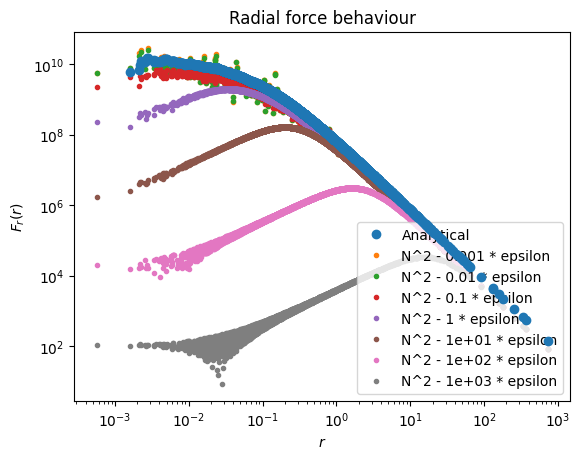

In [ ]:
## Plot the radial force behaviour
r = np.linalg.norm(particles[:,:3], axis=1)

plt.figure()
plt.title('Radial force behaviour')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$r$')
plt.ylabel('$F_r(r)$')

plt.plot(r, np.linalg.norm(analytical_force, axis=1), 'o', label="Analytical", zorder=10)

for e, f in zip(epsilon_range, n_squared_forces):
    plt.plot(r, np.linalg.norm(f, axis=1), '.', label=f"N^2 - {e:.1g} * epsilon")


plt.legend()
plt.show()



**Takeaways:**
- basic $N^2$ matches analytical solution without dropoff. but: noisy data from "bad" samples
- $N^2$ with softening matches analytical solution but has a dropoff. No noisy data.
    - softening $\approx 1 \varepsilon$ is a sweet spot since the dropoff is "late"

### Relation time

In [ ]:
# 